## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np # numpy library
import scipy.linalg as lng # linear algebra from scipy library
from sklearn import preprocessing as preproc # load preprocessing function
import seaborn as sns
sns.set() # Set searborn as default 
import pandas as pd
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_squared_error

import scipy.io as io
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV 

# Emmas import
from sklearn.model_selection import KFold
from sklearn import linear_model 
import math
from sklearn.impute import SimpleImputer
import warnings # to silence convergence warnings

## Load dataset

In [2]:
# Read the data

# Read data from csv file 
raw_data = pd.read_csv('case1Data.txt')

# Giving NaN values the correct NaN value 
raw_data = raw_data.replace(' NaN', np.nan)

# Splitting in X and y
y = raw_data['y']
X_num = raw_data.loc[:, ' x_ 1':' x_95'].astype(float) 
X_cat = raw_data.loc[:, ' C_ 1':' C_ 5'] 

In [3]:
X_cat

,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,H,H,I,K,J
1,K,H,J,G,G
2,I,H,G,H,G
3,NaN,H,K,K,G
4,G,H,H,K,H
...,...,...,...,...,...
95,I,H,J,G,G
96,I,H,K,I,K
97,NaN,H,I,K,J
98,I,H,K,H,G


In [4]:
X_num.isna().sum().mean() # Check for NaN values

14.536842105263158

In [5]:
X_num[' x_ 1'].isna().sum() # Check for NaN values

16

## Initial data investigation 

In [6]:
# Basic stats and distribution

# Basic stats 
raw_data.describe()


,y
count,100.000000
mean,-9.449225
std,54.637475
min,-178.046246
25%,-44.109740
50%,-5.108532
75%,24.499702
max,113.446867


In [117]:
# Compute the correlation matrix
corr_matrix = X_num.corr()

# Flatten the correlation matrix to a long format
corr_long = corr_matrix.unstack().reset_index()
corr_long.columns = ['Feature1', 'Feature2', 'Correlation']

# Remove self-correlations (where Feature1 and Feature2 are the same)
corr_long = corr_long[corr_long['Feature1'] != corr_long['Feature2']]

# Remove duplicate pairs
corr_long['FeaturePair'] = corr_long.apply(lambda x: tuple(sorted([x['Feature1'], x['Feature2']])), axis=1)
corr_long = corr_long.drop_duplicates(subset=['FeaturePair'])

# Sort by absolute value of correlation coefficient
corr_long['AbsCorrelation'] = corr_long['Correlation'].abs()
top40_pairs = corr_long.sort_values(by='AbsCorrelation', ascending=False).head(40)

# The top 20 pairs are in top20_pairs
corr_long.sort_values(by='AbsCorrelation', ascending=False).head(100)

,Feature1,Feature2,Correlation,FeaturePair,AbsCorrelation
1962,x_21,x_63,0.756355,"( x_21, x_63)",0.756355
1416,x_15,x_87,0.752131,"( x_15, x_87)",0.752131
3555,x_38,x_41,0.736807,"( x_38, x_41)",0.736807
2801,x_30,x_47,0.717755,"( x_30, x_47)",0.717755
6156,x_65,x_77,0.716798,"( x_65, x_77)",0.716798
...,...,...,...,...,...
3473,x_37,x_54,0.641827,"( x_37, x_54)",0.641827
443,x_ 5,x_64,0.640767,"( x_ 5, x_64)",0.640767
3504,x_37,x_85,0.639621,"( x_37, x_85)",0.639621
802,x_ 9,x_43,0.639544,"( x_ 9, x_43)",0.639544


y        1.000000
 x_62    0.687672
 x_ 3    0.623360
 x_54    0.615380
 x_13    0.611021
           ...   
 x_73    0.200182
 x_80    0.191484
 x_28    0.176067
 x_36    0.116533
 x_19    0.095690
Name: y, Length: 96, dtype: float64


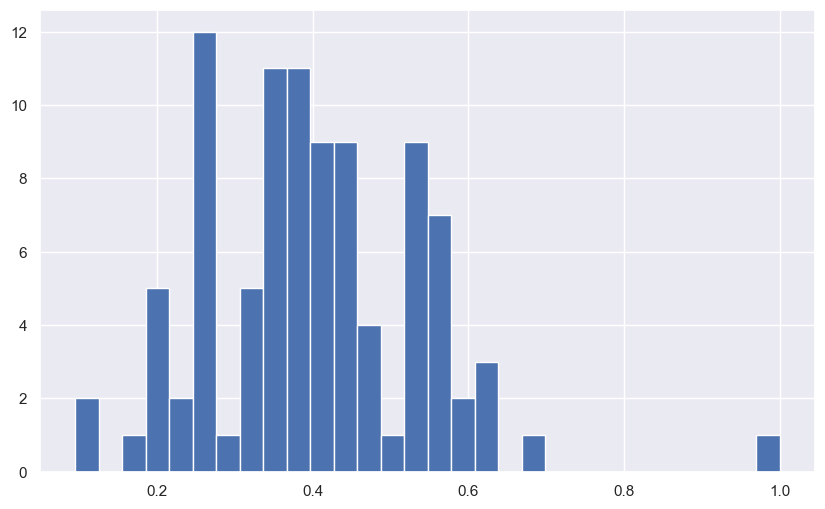

In [116]:
# Correlation with target
correlation_matrix = raw_data.iloc[:, :-5].corr()
print(correlation_matrix['y'].sort_values(ascending=False))
histogram = correlation_matrix['y'].hist(bins=30, figsize=(10, 6))

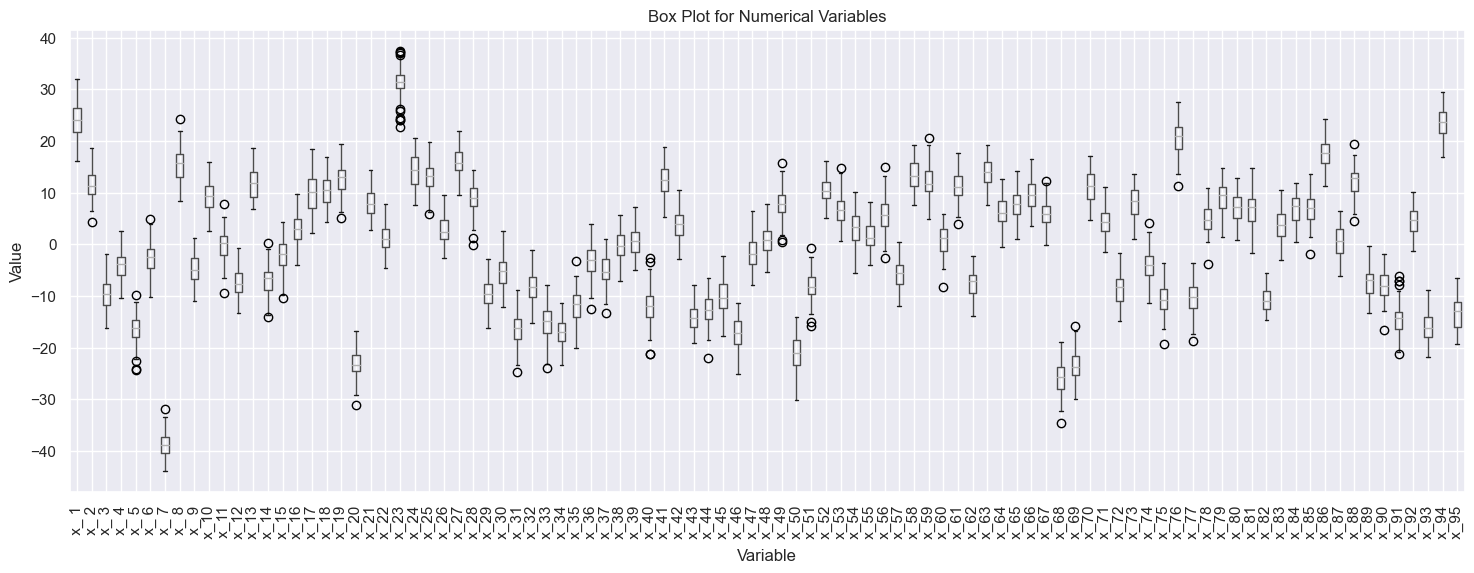

In [23]:

# Create box plots for numerical variables
plt.figure(figsize=(18, 6))  # Adjust the figure size if needed
X_num.boxplot(rot=90)
plt.title('Box Plot for Numerical Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.show()

## Models

### RIGHT BRANCH: Class data kept  

Modtaget af rasmus til hyper parameter tuning: 

In [ ]:
# n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]

# param_grid = {'n_estimators': n_estimators,
#                 'max_depth': max_depth,
#                 'min_samples_split': min_samples_split,
#                 'min_samples_leaf': min_samples_leaf,
#                 'bootstrap': bootstrap}

# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, n_jobs=-1)
# rf_random.fit(X_cat_np, y)

In [6]:
# Label encoder for categorical variables 
mapping = {'G': 1, 'H': 2, 'I': 3, 'J': 4, 'K': 5}
X_cat = X_cat.applymap(lambda x: mapping.get(str(x).strip(), x))
X_cat

,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,2.0,2,3,5,4
1,5.0,2,4,1,1
2,3.0,2,1,2,1
3,NaN,2,5,5,1
4,1.0,2,2,5,2
...,...,...,...,...,...
95,3.0,2,4,1,1
96,3.0,2,5,3,5
97,NaN,2,3,5,4
98,3.0,2,5,2,1


In [7]:
# Now X_num and X_cat are ready merging 
X = pd.concat([X_num, X_cat], axis=1)

In [8]:
[n,p] = X.shape
(n, p)

(100, 100)

In [9]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the euclidian lenghts of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the euclidian lenghts of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the the L2 norms of the variables
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is 0 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths

#### Elastic net

In [11]:
# Set up the lambda range and other variables
lambdas = np.logspace(-3, 1, num=20)  # Your range for alpha
Err_tr = np.zeros(len(lambdas))
Err_tst = np.zeros(len(lambdas))

# Preparing the ElasticNet model (consider removing explicit lambda range if letting ENCV choose best)
# The 'llinear_model1_ratio' close to 1 would make it similar to LASSO; for pure LASSO, set l1_ratio=1
model = linear_model.ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 1], alphas=lambdas)

with warnings.catch_warnings():  # To ignore convergence warnings
    warnings.simplefilter("ignore")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

    # Data preprocessing (impute, center, normalize)
    imp = SimpleImputer(strategy='mean')
    # Create the imputer object
    imp = SimpleImputer(strategy='mean')
    
    # Fit the imputer on the training data and transform training data and transform the test data (do not fit the imputer on the test data to avoid data leakage)
    X_train_imputed = imp.fit_transform(X_train)
    X_test_imputed = imp.transform(X_test)

    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.    
    y_train, mu = centerData(y_train)  # Center training response
    y_test = y_test - mu              # Use the mean value from the training response to center the test response

    X_train_imputed, mu = centerData(X_train_imputed)  # Center training data
    X_test_imputed = X_test_imputed - mu               # Use the mean from the training data to center the test data

    X_train_imputed, d = normalize(X_train_imputed)    # Normalize training data
    X_test_imputed = X_test_imputed / d                # Normalize test data using the scale of the train data columns


    # Fit the model
    model.fit(X_train_imputed, y_train)

    # Now the best alpha and l1_ratio can be extracted directly from the model
    optimal_alpha = model.alpha_
    optimal_l1_ratio = model.l1_ratio_

    # Note: With ElasticNetCV, there's no direct equivalent to beta as in manual regression, but you can use model.coef_
    
    # Print the details of the optimal model
    print("Elastic net:")
    print(f"Optimal alpha: {optimal_alpha}")
    print(f"Optimal l1_ratio: {optimal_l1_ratio}")

    # Predict on training and test data with the optimal model
    y_train_pred = model.predict(X_train_imputed)
    y_test_pred = model.predict(X_test_imputed)

    # Calculate RMSE for the training and test sets
    rmse_train_optimal = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test_optimal = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Print the RMSE results for the optimal model
    print("Training RMSE for the optimal model:", rmse_train_optimal)
    print("Testing RMSE for the optimal model:", rmse_test_optimal)




Elastic net:
Optimal alpha: 0.3359818286283781
Optimal l1_ratio: 1.0
Training RMSE for the optimal model: 20.727834288635478
Testing RMSE for the optimal model: 28.49567487847565


#### LARS

In [12]:
df = pd.concat([X, y], axis=1)
df

,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,x_10,...,x_92,x_93,x_94,x_95,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5,y
0,NaN,NaN,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,NaN,...,6.319109,NaN,26.197445,-9.913837,2.0,2,3,5,4,90.685036
1,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,NaN,-2.442164,10.303557,...,NaN,-12.880342,25.924603,-7.015803,5.0,2,4,1,1,60.844445
2,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,12.057741,...,2.664209,-15.803518,24.293073,-14.795709,3.0,2,1,2,1,18.062345
3,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,7.182760,...,5.004891,-13.879328,25.954304,-9.365574,NaN,2,5,5,1,-8.139839
4,25.400286,NaN,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,NaN,-7.341165,9.933879,...,5.101262,-16.938532,22.611184,-17.240003,1.0,2,2,5,2,-4.994792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,24.821083,14.377228,-7.899269,-5.531786,NaN,-3.732251,NaN,15.752089,NaN,13.040789,...,4.998234,NaN,NaN,-11.750148,3.0,2,4,1,1,12.574444
96,20.848176,9.238049,-11.921478,-6.374971,-18.648810,-3.019048,-41.358696,8.435083,-5.864114,6.372895,...,2.597797,-17.732465,20.164049,-15.924279,3.0,2,5,3,5,-109.414997
97,27.160523,10.134287,-10.920363,-3.231409,-18.474369,-2.431349,-38.280634,21.150995,-2.531643,12.875277,...,8.293394,-17.020511,23.697288,-10.619427,NaN,2,3,5,4,-11.548116
98,20.391153,10.180320,NaN,-5.296246,-17.612480,-6.472314,-38.292821,12.740686,NaN,4.037933,...,NaN,-17.575742,22.101534,-18.731196,3.0,2,5,2,1,-35.263761


In [18]:
CV = 5 
kf = KFold(n_splits=CV)
stop = n - math.ceil(n / CV)  # Make sure this calculation makes sense for your context
K = range(1, stop + 1)  # start from 1 to ensure valid 'n_nonzero_coefs' values


Err_tr = np.zeros((CV,len(K)))
Err_tst = np.zeros((CV, len(K))) 

############# LARS #############
for i, (train_index, test_index) in enumerate(kf.split(df)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # compute all LARS solutions
    for j in K:
        
        # Create the imputer object
        imp = SimpleImputer(strategy='mean')
        
        # Fit the imputer on the training data and transform training data and transform the test data (do not fit the imputer on the test data to avoid data leakage)
        X_train_imputed = imp.fit_transform(X_train)
        X_test_imputed = imp.transform(X_test)

        # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
        # We should perform CV "the right way" and keep test data unseen.    
        y_train, mu = centerData(y_train)  # Center training response
        y_test = y_test - mu              # Use the mean value from the training response to center the test response

        X_train_imputed, mu = centerData(X_train_imputed)  # Center training data
        X_test_imputed = X_test_imputed - mu               # Use the mean from the training data to center the test data

        X_train_imputed, d = normalize(X_train_imputed)    # Normalize training data
        X_test_imputed = X_test_imputed / d                # Normalize test data using the scale of the train data columns

        
        # Define and fit the Lars model
        reg = linear_model.Lars(n_nonzero_coefs=j, fit_path=False, fit_intercept=False, verbose=True, normalize=False)
        reg.fit(X_train_imputed, y_train)  # Use the imputed training data
        beta = reg.coef_.ravel()
        
        # Predict with this model, and find error
        YhatTr = X_train_imputed @ beta  # Use the imputed training data
        YhatTest = X_test_imputed @ beta  # Use the imputed test data
        
        # Calculate and store the training and test errors
        Err_tr[i, j-1] = np.mean((YhatTr - y_train)**2)  # Training error, Adjust index for zero-based indexing
        Err_tst[i, j-1] = np.mean((YhatTest - y_test)**2) # Test error


        
err_tr = np.sqrt(np.mean(Err_tr, axis=0)) # RMSE training over the CV folds
err_tst = np.sqrt(np.mean(Err_tst, axis=0)) # RMSE test over the CV folds
err_ste = np.std(Err_tst, axis=0)/np.sqrt(CV) # Note: we divide with sqrt(n) to get the standard error as opposed to the standard deviation


# Find the index of the minimum mean test RMSE
optimal_j_index = np.argmin(err_tst)

# Find the optimal number of non-zero coefficients (features)
optimal_j = K[optimal_j_index]

# Find the associated mean test RMSE
optimal_err_tst = err_tst[optimal_j_index]

# Find the standard error of the mean test RMSE at the optimal j
optimal_err_ste = err_ste[optimal_j_index]

# Print the optimal model details
print("LARS:")
print("Optimal number of non-zero coefficients:", optimal_j)
print("Associated mean test RMSE:", optimal_err_tst)
print("Standard error of the mean test RMSE:", optimal_err_ste)


# Create a plot of the training and test RMSE versus the number of non-zero coefficients
plt.figure(figsize=(10, 6))
plt.plot(K, err_tr, 'b', label='Training RMSE')
plt.plot(K, err_tst, 'r', label='Test RMSE')


# Adding titles and labels
plt.title('Training and Test RMSE vs. Number of Non-Zero Coefficients')
plt.xlabel('Number of Non-Zero Coefficients')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

TypeError: Lars.__init__() got an unexpected keyword argument 'alpha'

#### LASSO LARS

Optimal alpha: 0.25
Associated mean test RMSE: 25.72369305612094
Standard error of the mean test RMSE: 141.06232612977448
Associated mean training RMSE for optimal alpha: 16.662828633248395


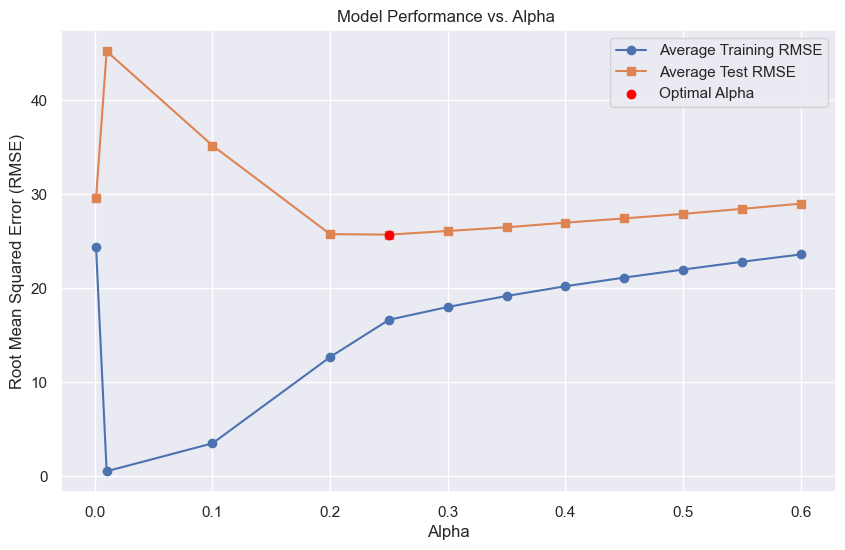

In [19]:
############# LASSO LARS #############
alphas = [0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.1, 0.01, 0.001]
Err_tr = np.zeros((CV, len(alphas)))
Err_tst = np.zeros((CV, len(alphas)))

for i, (train_index, test_index) in enumerate(kf.split(df)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # compute all LASSO LARS solutions
    for j, alpha in enumerate(alphas):
        
        # Create the imputer object
        imp = SimpleImputer(strategy='mean')
        
        # Fit the imputer on the training data and transform training data and transform the test data (do not fit the imputer on the test data to avoid data leakage)
        X_train_imputed = imp.fit_transform(X_train)
        X_test_imputed = imp.transform(X_test)

        # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
        # We should perform CV "the right way" and keep test data unseen.    
        y_train, mu = centerData(y_train)  # Center training response
        y_test = y_test - mu              # Use the mean value from the training response to center the test response

        X_train_imputed, mu = centerData(X_train_imputed)  # Center training data
        X_test_imputed = X_test_imputed - mu               # Use the mean from the training data to center the test data

        X_train_imputed, d = normalize(X_train_imputed)    # Normalize training data
        X_test_imputed = X_test_imputed / d                # Normalize test data using the scale of the train data columns

        
        # Fit LassoLars model with current alpha
        reg = linear_model.LassoLars(alpha=alpha)
        reg.fit(X_train_imputed, y_train)
        beta = reg.coef_.ravel()

        
        # Predict with this model, and find error
        YhatTr = X_train_imputed @ beta  # Use the imputed training data
        YhatTest = X_test_imputed @ beta  # Use the imputed test data
        
        # Calculate and store the training and test errors
        Err_tr[i, j-1] = np.mean((YhatTr - y_train)**2)  # Training error, Adjust index for zero-based indexing
        Err_tst[i, j-1] = np.mean((YhatTest - y_test)**2) # Test error


        

# Calculate the average RMSE over all CV folds for each alpha
mean_err_tr = np.sqrt(np.mean(Err_tr, axis=0))  # Average training RMSE for each alpha
mean_err_tst = np.sqrt(np.mean(Err_tst, axis=0))  # Average test RMSE for each alpha
std_err_tst = np.std(Err_tst, axis=0) / np.sqrt(CV)  # Standard error of test RMSE for each alpha

# Find the index of the smallest average test RMSE
optimal_alpha_index = np.argmin(mean_err_tst)
optimal_alpha = alphas[optimal_alpha_index]
optimal_err_tst = mean_err_tst[optimal_alpha_index]
optimal_err_ste = std_err_tst[optimal_alpha_index]

# Print the details of the optimal model
print("Optimal alpha:", optimal_alpha)
print("Associated mean test RMSE:", optimal_err_tst)
print("Standard error of the mean test RMSE:", optimal_err_ste)

# If you need, you can also print the RMSE for training to see how it compares
print("Associated mean training RMSE for optimal alpha:", mean_err_tr[optimal_alpha_index])

## Plot
plt.figure(figsize=(10, 6))

# Plotting the training and test RMSE against alphas
plt.plot(alphas, mean_err_tr, label='Average Training RMSE', marker='o')
plt.plot(alphas, mean_err_tst, label='Average Test RMSE', marker='s')
plt.scatter(optimal_alpha, optimal_err_tst, color='red', zorder=5, label='Optimal Alpha') # Highlighting the optimal alpha

# Adding titles, labels, and legend
plt.title('Model Performance vs. Alpha ')
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()

# Showing grid
plt.grid(True)

# Show the plot
plt.show()


#### LASSO

/Users/emmachristineberggreinandersen/.julia/conda/3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.604e+01, tolerance: 2.410e+01
  model = cd_fast.enet_coordinate_descent(
/Users/emmachristineberggreinandersen/.julia/conda/3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e+02, tolerance: 2.410e+01
  model = cd_fast.enet_coordinate_descent(
/Users/emmachristineberggreinandersen/.julia/conda/3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number o

Optimal alpha: 0.2
Associated mean test RMSE: 25.721824567385546
Standard error of the mean test RMSE: 140.99181880651776
Associated mean training RMSE for optimal alpha: 16.663103814186584


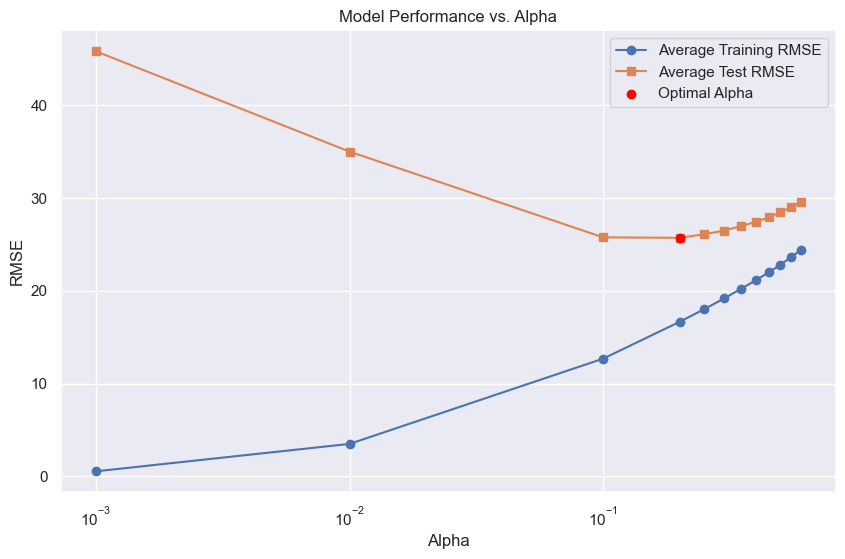

In [25]:
# Set up the alpha range and other variables
alphas = [0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.1, 0.01, 0.001]
CV = 5  # Number of cross-validation folds
kf = KFold(n_splits=CV)

# Prepare arrays to store results
Err_tr = np.zeros((CV, len(alphas)))
Err_tst = np.zeros((CV, len(alphas)))

# Start cross-validation
for i, (train_index, test_index) in enumerate(kf.split(df)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Data preprocessing (impute, center, normalize)
    imp = SimpleImputer(strategy='mean')
    X_train_imputed = imp.fit_transform(X_train)
    X_test_imputed = imp.transform(X_test)

    # Assuming centerData and normalize are functions you've defined previously
    y_train, y_mean = centerData(y_train)  # Center training response
    y_test = y_test - y_mean                # Center test response using the same mean

    X_train_imputed, x_mu = centerData(X_train_imputed)  # Center training data
    X_test_imputed = X_test_imputed - x_mu               # Center test data using the same mean

    X_train_imputed, x_scale = normalize(X_train_imputed)  # Normalize training data
    X_test_imputed = X_test_imputed / x_scale              # Normalize test data using the same scale

    # Iterate through alphas
    for j, alpha in enumerate(alphas):
        # Fit Lasso model with current alpha
        reg = linear_model.Lasso(alpha=alpha)
        reg.fit(X_train_imputed, y_train)
        
        # Predict and find error for both train and test datasets
        YhatTr = reg.predict(X_train_imputed)  # Use the model's predict method
        YhatTest = reg.predict(X_test_imputed)  # Use the model's predict method
        
        # Store the training and test errors (MSE)
        Err_tr[i, j] = mean_squared_error(y_train, YhatTr)  # Training error
        Err_tst[i, j] = mean_squared_error(y_test, YhatTest) # Test error

# Calculate the average RMSE over all CV folds for each alpha
mean_err_tr = np.sqrt(np.mean(Err_tr, axis=0))  # Average training RMSE for each alpha
mean_err_tst = np.sqrt(np.mean(Err_tst, axis=0))  # Average test RMSE for each alpha
std_err_tst = np.std(Err_tst, axis=0) / np.sqrt(CV)  # Standard error of test RMSE for each alpha

# Find the index of the smallest average test RMSE
optimal_alpha_index = np.argmin(mean_err_tst)
optimal_alpha = alphas[optimal_alpha_index]
optimal_err_tst = mean_err_tst[optimal_alpha_index]
optimal_err_ste = std_err_tst[optimal_alpha_index]

# Print the details of the optimal model
print("Optimal alpha:", optimal_alpha)
print("Associated mean test RMSE:", optimal_err_tst)
print("Standard error of the mean test RMSE:", optimal_err_ste)
print("Associated mean training RMSE for optimal alpha:", mean_err_tr[optimal_alpha_index])

# Plot the training and test RMSE against alphas
plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_err_tr, label='Average Training RMSE', marker='o')
plt.plot(alphas, mean_err_tst, label='Average Test RMSE', marker='s')
plt.scatter(optimal_alpha, optimal_err_tst, color='red', zorder=5, label='Optimal Alpha')  # Highlight the optimal alpha
plt.xscale('log')  # Since alphas vary on a log scale, this makes the plot easier to interpret
plt.title('Model Performance vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


#### Random Forest CLARA

In [52]:
# Using OOB to impute missing values -> this introduces bias 

from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy='mean') 
X_imp = imputer.fit_transform(X) 

In [85]:
# add ten features of random noise to X_imp
X_imp = np.hstack([X_imp, np.random.randn(X_imp.shape[0], 10)])

In [86]:
# Random forest regressor
clf = RandomForestRegressor(bootstrap = True, oob_score = True, criterion = 'squared_error', random_state = 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, random_state=0, shuffle=False)


# Try to experiment with criterion, number of estimators, max_depth, min_samples_leaf 
# Try to add more of the parameters from the model and then add them to this dict to see how it affects the model.
param_grid = {
    'n_estimators': range(5,10), # range(5,101)
    'max_depth': range(1,10), # range(1,11)
    'max_features': range(10,20,20) # range(10,250,20)
}

rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, verbose = 2, n_jobs = -1)

# Fit the grid search model
rf_grid.fit(X_train, y_train)

#Save the results in a dataframe to disk
df = pd.DataFrame(rf_grid.cv_results_)
df.to_csv('CrossValidationResultsRandomForest.csv')

print(rf_grid.best_estimator_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used

[CV] END .......max_depth=1, max_features=10, n_estimators=5; total time=   0.0s
[CV] END .......max_depth=1, max_features=10, n_estimators=5; total time=   0.0s
[CV] END .......max_depth=1, max_features=10, n_estimators=6; total time=   0.0s
[CV] END .......max_depth=1, max_features=10, n_estimators=6; total time=   0.0s
[CV] END .......max_depth=1, max_features=10, n_estimators=5; total time=   0.0s
[CV] END .......max_depth=1, max_features=10, n_estimators=5; total time=   0.0s
[CV] END .......max_depth=1, max_features=10, n_estimators=5; total time=   0.0s
[CV] END .......max_depth=1, max_features=10, n_estimators=6; total time=   0.0s
[CV] END .......max_depth=1, max_features=10, n_estimators=6; total time=   0.0s
[CV] END .......max_depth=1, max_features=10, n_estimators=6; total time=   0.0s
[CV] END .......max_depth=1, max_features=10, n_estimators=7; total time=   0.0s
[CV] END .......max_depth=1, max_features=10, n_estimators=7; total time=   0.0s
[CV] END .......max_depth=1,

/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used

[CV] END .......max_depth=8, max_features=10, n_estimators=6; total time=   0.0s
[CV] END .......max_depth=7, max_features=10, n_estimators=7; total time=   0.1s
[CV] END .......max_depth=7, max_features=10, n_estimators=9; total time=   0.1s
[CV] END .......max_depth=8, max_features=10, n_estimators=8; total time=   0.1s
[CV] END .......max_depth=9, max_features=10, n_estimators=5; total time=   0.0s
[CV] END .......max_depth=7, max_features=10, n_estimators=6; total time=   0.1s
[CV] END .......max_depth=6, max_features=10, n_estimators=9; total time=   0.1s
[CV] END .......max_depth=8, max_features=10, n_estimators=6; total time=   0.0s
[CV] END .......max_depth=9, max_features=10, n_estimators=5; total time=   0.0s
[CV] END .......max_depth=8, max_features=10, n_estimators=6; total time=   0.0s
[CV] END .......max_depth=8, max_features=10, n_estimators=9; total time=   0.0s
[CV] END .......max_depth=7, max_features=10, n_estimators=5; total time=   0.0s
[CV] END .......max_depth=7,

 OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_for

_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/clarareginekold/opt/anaconda3/envs/Introduction_to_BA/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [70]:
rf_grid.best_estimator_

RandomForestRegressor(max_depth=9, max_features=10, n_estimators=5,
                      oob_score=True, random_state=0)

Text(0, 0.5, 'Mean test accuracy')

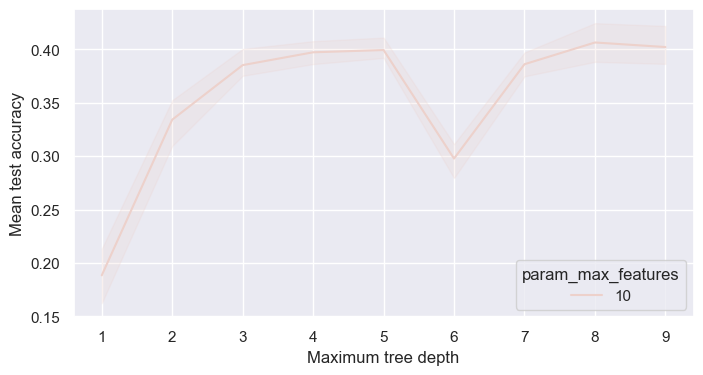

In [71]:
# If you just wanna read the saved results. 
df = pd.read_csv(r'CrossValidationResultsRandomForest.csv')
fig, ax = plt.subplots(figsize=(8,4))
_ = sns.lineplot(data=df, x='param_max_depth', y='mean_test_score', hue='param_max_features', ax=ax)
ax.set_xlabel('Maximum tree depth')
ax.set_ylabel('Mean test accuracy')

In [87]:
y_pred = rf_grid.predict(X_test)

In [88]:
# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(f"Root mean Squared Error: {rmse}") 

Root mean Squared Error: 55.28822807814442


In [89]:
from sklearn.inspection import permutation_importance

# Mean importance values across permutations
imp = permutation_importance(rf_grid, X_train, y_train, n_repeats=10,random_state=0, scoring = 'neg_root_mean_squared_error')
imp.importances_mean 
# The higher the mean importance, the more impactful the feature is in terms of model performance.

array([ 0.00000000e+00,  0.00000000e+00,  4.26531552e-01,  0.00000000e+00,
        1.48521927e+00,  0.00000000e+00,  0.00000000e+00,  2.51563896e-01,
        1.79654100e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        9.11456078e-01,  2.03146469e-01,  1.84227636e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.07003306e+00,  0.00000000e+00,
        0.00000000e+00,  1.75919810e-01,  4.00820492e-01,  3.79651310e+00,
        1.19998177e+00,  1.17749530e+00,  9.34043149e-04,  1.54057926e+00,
        0.00000000e+00,  0.00000000e+00,  5.61643411e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.82159839e-01,  0.00000000e+00,  1.76893815e+00,  0.00000000e+00,
        0.00000000e+00,  8.33524768e-01,  4.66805033e-01,  3.83319270e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.07941580e-01,
        2.14366921e-01,  1.94589444e-01,  7.73962873e-01,  5.83065556e-02,
        1.13255175e+00,  

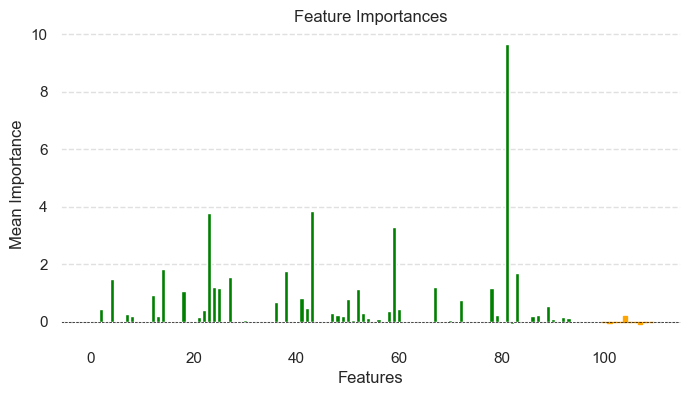

In [115]:
# Plot 

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_facecolor('white')
bars = ax.bar(range(len(imp.importances_mean)), imp.importances_mean, color='green')
for i in range(-10, 0):
    bars[i].set_color('orange')
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Add a horizontal line at y=0 for reference
# plt.xticks(range(len(imp.importances_mean)), X.columns, rotation=45, ha='right')  
ax.set_xlabel('Features')
ax.set_ylabel('Mean Importance')
ax.set_title('Feature Importances')
ax.grid(axis='y', linestyle='--', alpha=0.7, color="lightgrey")
plt.show()

#### Gradient Boosting Regressor CLARA

In [ ]:
# Gradient Boosting Regressor 

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Create and fit a HistGradientBoostingRegressor
hist_gb_regressor = HistGradientBoostingRegressor(random_state=42)
hist_gb_regressor.fit(X, y)

# Make predictions on the test set
# y_pred = hist_gb_regressor.predict(X_test)

# Evaluate the model
#mse = mean_squared_error(y_test, y_pred)
#print(f"Mean Squared Error: {mse}")


### LEFT BRANCH: Models on class data RASMUS

## Model Validation

In [ ]:

 


###############################################################
# Fix missing data 
###############################################################

# Fix missing data for numerical columns
for column in X_num.columns:
    if X_num[column].isnull().any():
        mean_value = X_num[column].mean()
        X_num = X_num[column].fillna(mean_value, inplace=True)

# Fix missing data for categorical columns
for column in X_cat.columns:
    if X_cat[column].isnull().any():
        mode_value = X_cat[column].mode().iloc[0]  # using mode for categorical data
        X_cat = X_cat[column].fillna(mode_value, inplace=True)

# Concatenate the imputed numerical and categorical data
data = pd.concat([y, X_num, X_cat], axis=1)


###############################################################
# Feature handling: categorical data 
###############################################################
# https://www.saedsayad.com/decision_tree_reg.htm
# We do decison tree regression for the categorical data
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor # it does one hot encoding in the background
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Make it numpy
X_cat_np = X_cat.to_numpy()

# Label encode the categorical data, so that the labels are translated to usable data
label_encoders = []
for i in range(len(X_cat_np[0])):
    label_encoders.append(LabelEncoder())
    X_cat_np[:, i] = label_encoders[i].fit_transform([row[i] for row in X_cat_np])

regressor = DecisionTreeRegressor()
regressor.fit(X_cat_np, y)
y_pred = regressor.predict(X_cat_np)

mean_squared_error(y, y_pred)

importances = regressor.feature_importances_




###############################################################
# Other data transformations 
###############################################################



###############################################################
# Prediction model: ??? 
###############################################################